In [63]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [64]:
df = pd.read_csv('output.csv')
X = df.iloc[:, 1:13]
y = df.iloc[:, -1]
print(X)
print(y)

      long_url_len  has_at  ...  is_good_at_alexa_traffic  is_in_dns_record
0                1       1  ...                         1                 1
1                1       1  ...                         1                 1
2                1       1  ...                         1                 1
3                1       1  ...                         1                 1
4                1       1  ...                         1                 1
...            ...     ...  ...                       ...               ...
1953             1       1  ...                         2                 1
1954             1       1  ...                         2                 1
1955             1       1  ...                         2                 1
1956             1       1  ...                         2                 1
1957             1       1  ...                         2                 1

[1958 rows x 12 columns]
0       2
1       2
2       2
3       2
4       2
       ..
19

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [67]:
encoder = OneHotEncoder(sparse=False)
X_train_onehot = encoder.fit_transform(X_train)
X_test_onehot = encoder.transform(X_test)
pickle.dump(encoder, open("one_hot_encoder", 'wb'))

In [68]:
def grid_search_svm(X_train_onehot, y_train):
    svc = svm.SVC()
    parameters = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [10, 1, 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }
    clf = GridSearchCV(svc, parameters, cv=3)
    clf_result = clf.fit(X_train_onehot, y_train)
    return clf_result.best_params_


best_params_svm = grid_search_svm(X_train_onehot, y_train)
print('best_params_svm: ', best_params_svm)
print("going to use: svm.SVC(C=10, gamma=0.1, kernel='rbf', probability=True)")

best_params_svm:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
going to use: svm.SVC(C=10, gamma=0.1, kernel='rbf', probability=True)


In [77]:
def plot_confusion_matrix(y_val, y_pred):
    cm = confusion_matrix(y_val, y_pred, [2, 1])
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

def get_metrics(model, y, X_onehot):
    tp, fn, fp, tn = metrics.confusion_matrix(y, model.predict(X_onehot)).ravel()
    accuracy = (tn + tp) / (fp + fn + tp + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fpr = fp / (fp + tn)
    f1 = 2 * precision * recall / (precision + recall)
    return accuracy, precision, recall, fpr, f1

accuracy:  0.9668367346938775
precision:  0.9860626049650442
recall:  0.9691780821917808
fpr:  0.04
f1:  0.9775454624075333


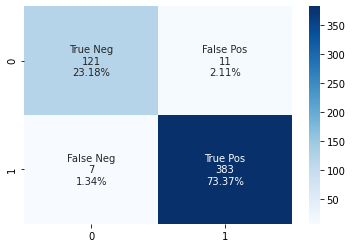

In [80]:
def run_svm(X_train_onehot, y_train):
    score = []
    kf = KFold(n_splits=3, shuffle=True, random_state=709)
    svc = svm.SVC(C=10, gamma=0.1, kernel='rbf', probability=True)
    i = 0
    for train, test in kf.split(X_train_onehot):
        svc = svc.fit(X_train_onehot[train], y_train[train])
        accuracy, precision, recall, fpr, f1 = get_metrics(svc, y_test, X_test_onehot)
        score.append((accuracy, precision, recall, fpr, f1))
        if i == 0:
            plot_confusion_matrix(y_train[test], svc.predict(X_train_onehot[test]))
            pickle.dump(svc, open("svm_model", 'wb'))
        i += 1
    return np.mean(score, axis=0)


metric_svm_scores = run_svm(X_train_onehot, y_train)
print('accuracy: ', metric_svm_scores[0])
print('precision: ', metric_svm_scores[1])
print('recall: ', metric_svm_scores[2])
print('fpr: ', metric_svm_scores[3])
print('f1: ', metric_svm_scores[4])